# Tutorial: Applying Periodic Boundary Conditions in PINNs to solve the Helmholtz Problem

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial9/tutorial.ipynb)

This tutorial demonstrates how to solve a one-dimensional Helmholtz equation with periodic boundary conditions (PBC) using Physics-Informed Neural Networks (PINNs).  
We will use standard PINN training, augmented with a periodic input expansion as introduced in [*An Expert’s Guide to Training Physics-Informed Neural Networks*](https://arxiv.org/abs/2308.08468).

Let's start with some useful imports:


In [ ]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import torch
import matplotlib.pyplot as plt
import warnings

from pina import Condition, Trainer
from pina.problem import SpatialProblem
from pina.model import FeedForward
from pina.model.block import PeriodicBoundaryEmbedding  # The PBC module
from pina.solver import PINN
from pina.domain import CartesianDomain
from pina.equation import Helmholtz
from pina.callback import MetricTracker

warnings.filterwarnings("ignore")

## Problem Definition

The one-dimensional Helmholtz problem is mathematically expressed as:

$$
\begin{cases}
\frac{d^2}{dx^2}u(x) - \lambda u(x) - f(x) &= 0 \quad \text{for } x \in (0, 2) \\
u^{(m)}(x = 0) - u^{(m)}(x = 2) &= 0 \quad \text{for } m \in \{0, 1, \dots\}
\end{cases}
$$

In this case, we seek a solution that is $C^{\infty}$ (infinitely differentiable) and periodic with period 2, over the infinite domain $x \in (-\infty, \infty)$. 

A classical PINN approach would require enforcing periodic boundary conditions (PBC) for all derivatives—an infinite set of constraints—which is clearly infeasible.

To address this, we adopt a strategy known as *coordinate augmentation*. In this approach, we apply a coordinate transformation $v(x)$ such that the transformed inputs naturally satisfy the periodicity condition:

$$
u^{(m)}(x = 0) - u^{(m)}(x = 2) = 0 \quad \text{for } m \in \{0, 1, \dots\}
$$

For demonstration purposes, we choose the specific parameters:

- $\lambda = -10\pi^2$
- $f(x) = -6\pi^2 \sin(3\pi x) \cos(\pi x)$

These yield an analytical solution:

$$
u(x) = \sin(\pi x) \cos(3\pi x)
$$

In [2]:
def forcing_term(x):
    pi = torch.pi
    return -6.0 * pi**2 * torch.sin(3 * pi * x) * torch.cos(pi * x)


helmholtz_equation = Helmholtz(k=10 * torch.pi**2, forcing_term=forcing_term)


class Helmholtz(SpatialProblem):
    output_variables = ["u"]
    spatial_domain = CartesianDomain({"x": [0, 2]})

    # here we write the problem conditions
    conditions = {
        "phys_cond": Condition(
            domain=spatial_domain, equation=helmholtz_equation
        ),
    }

    def solution(self, pts):
        return torch.sin(torch.pi * pts) * torch.cos(3.0 * torch.pi * pts)


problem = Helmholtz()

# let's discretise the domain
problem.discretise_domain(200, "grid", domains=["phys_cond"])

As usual, the Helmholtz problem is implemented in **PINA** as a class. The governing equations are defined as `conditions`, which must be satisfied within their respective domains. The `solution` represents the exact analytical solution, which will be used to evaluate the accuracy of the predicted solution.

For selecting collocation points, we use Latin Hypercube Sampling (LHS), a common strategy for efficient space-filling in high-dimensional domains 

## Solving the Problem with a Periodic Network

Any $\mathcal{C}^{\infty}$ periodic function  $u : \mathbb{R} \rightarrow \mathbb{R}$ with period $L \in \mathbb{N}$  
can be constructed by composing an arbitrary smooth function  $f : \mathbb{R}^n \rightarrow \mathbb{R}$ with a smooth, periodic mapping$v : \mathbb{R} \rightarrow \mathbb{R}^n$ of the same period $L$. That is,

$$
u(x) = f(v(x)).
$$

This formulation is general and can be extended to arbitrary dimensions.  
For more details, see [*A Method for Representing Periodic Functions and Enforcing Exactly Periodic Boundary Conditions with Deep Neural Networks*](https://arxiv.org/pdf/2007.07442).

In our specific case, we define the periodic embedding as:

$$
v(x) = \left[1, \cos\left(\frac{2\pi}{L} x\right), \sin\left(\frac{2\pi}{L} x\right)\right],
$$

which constitutes the coordinate augmentation. The function $f(\cdot)$ is approximated by a neural network $NN_{\theta}(\cdot)$, resulting in the approximate PINN solution:

$$
u(x) \approx u_{\theta}(x) = NN_{\theta}(v(x)).
$$

In **PINA**, this is implemented using the `PeriodicBoundaryEmbedding` layer for $v(x)$,  
paired with any `pina.model` to define the neural network $NN_{\theta}$.  

Let’s see how this is put into practice!



In [3]:
# we encapsulate all modules in a torch.nn.Sequential container
model = torch.nn.Sequential(
    PeriodicBoundaryEmbedding(input_dimension=1, periods=2),
    FeedForward(
        input_dimensions=3,  # output of PeriodicBoundaryEmbedding = 3 * input_dimension
        output_dimensions=1,
        layers=[64, 64],
    ),
)

As simple as that!

In higher dimensions, you can specify different periods for each coordinate using a dictionary.  
For example, `periods = {'x': 2, 'y': 3, ...}` indicates a periodicity of 2 in the $x$ direction,  
3 in the $y$ direction, and so on.

We will now solve the problem using the usual `PINN` and `Trainer` classes. After training, we'll examine the losses using the `MetricTracker` callback from `pina.callback`.

In [ ]:
solver = PINN(problem=problem, model=model)
trainer = Trainer(
    solver,
    max_epochs=2000,
    accelerator="cpu",
    enable_model_summary=False,
    callbacks=[MetricTracker()],
)
trainer.train()

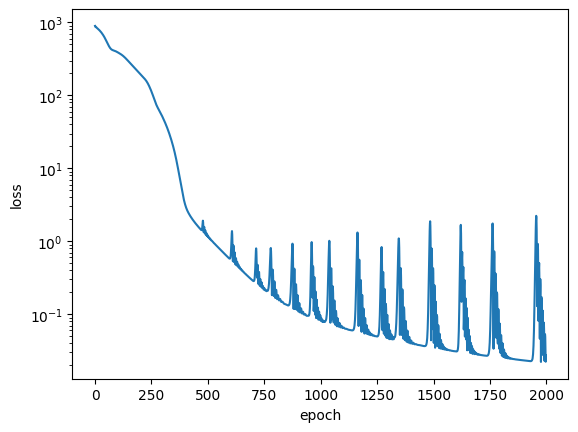

In [5]:
# plot loss
trainer_metrics = trainer.callbacks[0].metrics
plt.plot(
    range(len(trainer_metrics["train_loss"])), trainer_metrics["train_loss"]
)
# plotting
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")

We are going to plot the solution now!

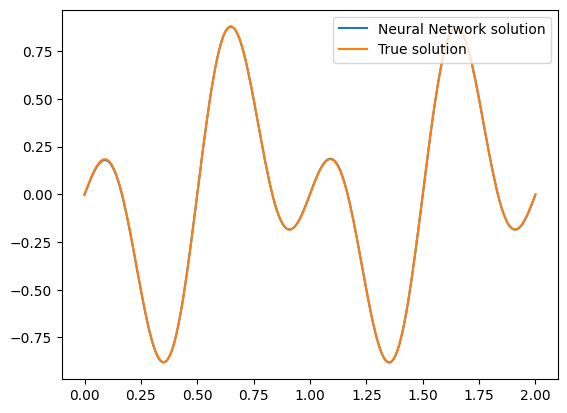

In [6]:
pts = solver.problem.spatial_domain.sample(256, "grid", variables="x")
predicted_output = solver(pts).extract("u").tensor.detach()
true_output = solver.problem.solution(pts)
plt.plot(pts.extract(["x"]), predicted_output, label="Neural Network solution")
plt.plot(pts.extract(["x"]), true_output, label="True solution")
plt.legend()

Great, they overlap perfectly! This seems a good result, considering the simple neural network used to some this (complex) problem. We will now test the neural network on the domain $[-4, 4]$ without retraining. In principle the periodicity should be present since the $v$ function ensures the periodicity in $(-\infty, \infty)$.

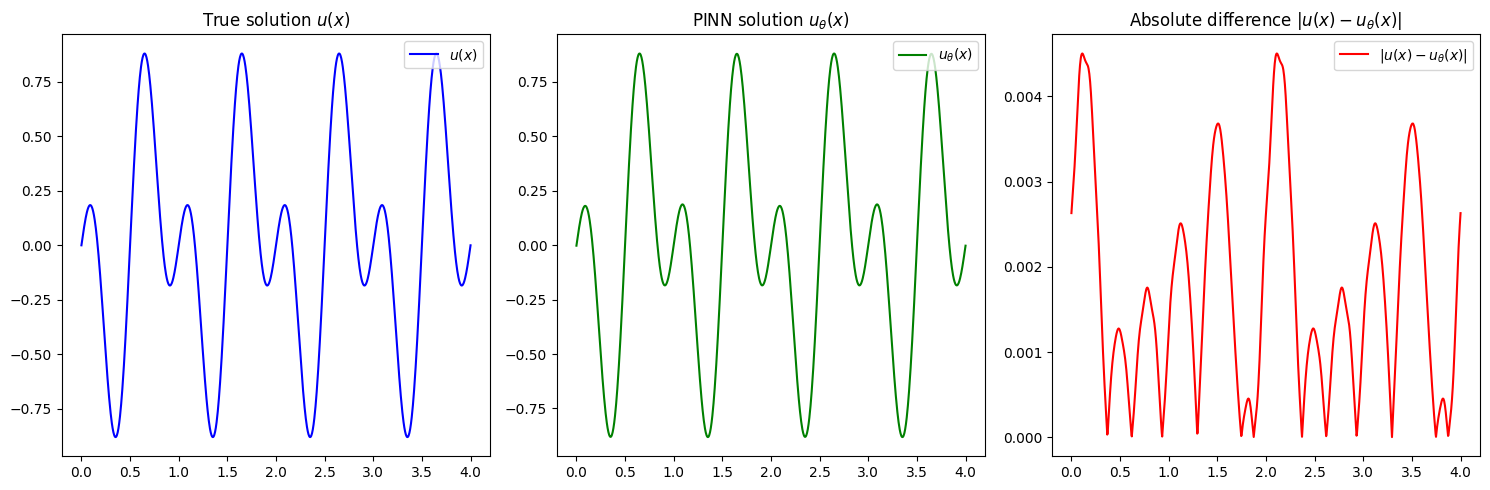

In [7]:
# plotting solution
with torch.no_grad():
    # Notice here we put [-4, 4]!!!
    new_domain = CartesianDomain({"x": [0, 4]})
    x = new_domain.sample(1000, mode="grid")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Plot 1
    axes[0].plot(x, problem.solution(x), label=r"$u(x)$", color="blue")
    axes[0].set_title(r"True solution $u(x)$")
    axes[0].legend(loc="upper right")
    # Plot 2
    axes[1].plot(x, solver(x), label=r"$u_{\theta}(x)$", color="green")
    axes[1].set_title(r"PINN solution $u_{\theta}(x)$")
    axes[1].legend(loc="upper right")
    # Plot 3
    diff = torch.abs(problem.solution(x) - solver(x))
    axes[2].plot(x, diff, label=r"$|u(x) - u_{\theta}(x)|$", color="red")
    axes[2].set_title(r"Absolute difference $|u(x) - u_{\theta}(x)|$")
    axes[2].legend(loc="upper right")
    # Adjust layout
    plt.tight_layout()
    # Show the plots
    plt.show()

It's clear that the network successfully captures the periodicity of the solution, with the error also exhibiting a periodic pattern. Naturally, training for a longer duration or using a more expressive neural network could further improve the results.
## What's next?

Congratulations on completing the one-dimensional Helmholtz tutorial with **PINA**! Here are a few directions you can explore next:

1. **Train longer or with different architectures**: Experiment with extended training or modify the network's depth and width to evaluate improvements in accuracy.

2. **Apply `PeriodicBoundaryEmbedding` to time-dependent problems**: Explore more complex scenarios such as spatiotemporal PDEs (see the official documentation for examples).

3. **Try extra feature training**: Integrate additional physical or domain-specific features to guide the learning process more effectively.

4. **...and many more!**: Extend to higher dimensions, test on other PDEs, or even develop custom embeddings tailored to your problem.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).